# 使用 Gemma、Weaviate 和 LlamaIndex 构建高级 RAG

本 Notebook 展示了构建高级检索增强生成（RAG）管道的基本步骤，使用以下构建模块：

* 通过 Kaggle 模型使用 [Gemma](https://www.kaggle.com/models/google/gemma) 模型，一个Google 的开源大型语言模型 (LLM)。
* [Weaviate](https://weaviate.io) 的开源向量数据库，用于外部上下文。
* [LlamaIndex](https://www.llamaindex.ai/) 用于编排。


**要了解构建** 简单 RAG 管道 **的教程，您可以查看我之前的 Notebook [RAG with Gemma on HF 🤗 and Weaviate in DSPy](https://www.kaggle.com/code/chenxucool/rag-with-gemma-on-hf-and-weaviate-in-dspy)。**

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 什么是高级 RAG？

**高级 RAG** 是一种 RAG 范式，它包含一系列技术，专门用于解决简单 RAG 的已知局限性。  
下图左侧展示了一个简单的 RAG 工作流程，右侧则展示了高级 RAG 技术如何被分类为以下几种：
* 检索前技术
* 检索技术
* 检索后技术

这些分类在论文《Retrieval-augmented generation for large language models: A survey》[2] 中进行了讨论。

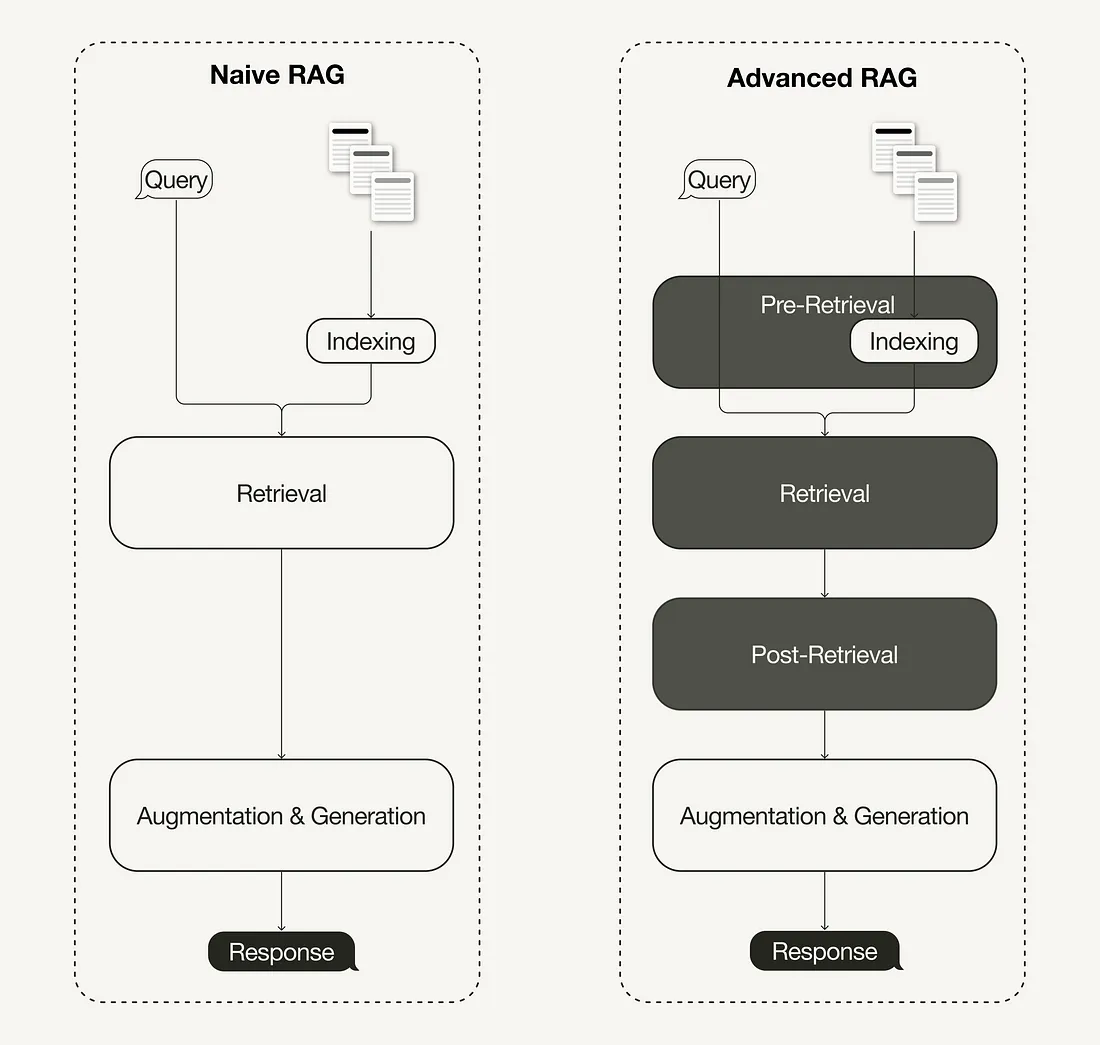

*（图片由作者 [Leonie](https://www.kaggle.com/iamleonie) 提供，最初发布于 [高级检索增强生成：从理论到 LlamaIndex 的实现](https://medium.com/p/4de1464a9930)）*

本 Notebook 为您展示了使用 LlamaIndex 的一些高级 RAG 技术。具体来说，我们将探索以下技术：
* 检索前技术：[自动检索（元数据过滤）](https://docs.llamaindex.ai/en/stable/examples/vector_stores/chroma_auto_retriever.html)
* 检索技术：[混合搜索](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo-Hybrid.html)
* 检索后技术：[重排序](https://docs.llamaindex.ai/en/latest/module_guides/querying/node_postprocessors/node_postprocessors.html#sentencetransformerrerank)，[少样本提示工程](https://docs.llamaindex.ai/en/stable/examples/prompts/prompts_rag.html#adding-few-shot-examples)

如果您想了解更多高级 RAG 技术的想法，可以查看原作者的这篇文章 [高级检索增强生成：从理论到 LlamaIndex 的实现](https://medium.com/p/4de1464a9930)，其中讨论了多种高级 RAG 技术，并实现了一些技术，例如句子窗口检索。

# 什么是 LlamaIndex？

**LlamaIndex**（原名 GPT Index）是一个开源的框架，专门设计用于将大语言模型（LLMs）与外部数据源连接。其主要目的是帮助开发者更容易地将语言模型应用于复杂的查询任务中，尤其是那些涉及到大量异构数据的场景。LlamaIndex 的核心功能在于构建索引结构，方便语言模型快速、高效地访问、检索和理解数据。

LlamaIndex 的关键特性包括：

1. **数据集成**：支持从各种数据源（如数据库、文档、API等）导入数据，生成可供语言模型使用的索引。
2. **索引结构**：提供多种索引结构（如向量索引、关键词索引等），帮助更快、更精确地查询。
3. **增强查询能力**：通过索引优化复杂查询，使语言模型能够从大量数据中提取相关信息。
4. **模块化设计**：可根据不同应用场景进行定制，适用于知识问答、文档搜索等任务。

它为开发者提供了一种高效的方法，将语言模型的自然语言处理能力与实际业务中的数据相结合，增强模型在现实环境中的实用性。

# 什么是 Weaviate？
**Weaviate** 是一个开源的分布式向量搜索引擎（数据库），专门用于存储、管理和检索基于语义的非结构化数据。它的核心功能是利用机器学习模型将数据转化为向量，并通过向量搜索技术来进行高效的相似性匹配。这使得 Weaviate 特别适用于自然语言处理、图像搜索、推荐系统等需要通过语义理解进行信息检索的场景。

Weaviate 的主要特性包括：

1. **向量搜索**：通过将文本、图像等数据编码为高维向量，可以进行快速的相似性搜索和匹配。
2. **语义理解**：内置的神经网络模型可以理解数据的语义，从而提供更智能的搜索结果。
3. **可扩展性**：支持水平扩展，适合处理大规模数据集。
4. **模块化**：支持插件式架构，允许用户根据需求集成不同的模型（如 Hugging Face 的模型）进行自定义查询。
5. **多种数据类型支持**：支持文本、图像、视频等多种数据类型的索引与搜索。

Weaviate 是语义搜索和 AI 驱动的数据处理场景中的一个强大工具，常用于构建智能搜索引擎、推荐系统、知识图谱等应用。

# 先决条件

要跟随本教程，您需要满足以下先决条件：
1. 在notebook中启用 GPU
2. 安装以下软件包：

time: 2min 5s

In [2]:
%%time
# 下面这些库需要安装最新版本，kaggle也要使用最近环境（Always use latest environment），避免版本冲突报错
!pip install -U keras-nlp
!pip install -U keras>3
!pip install -U llama_index
!pip install llama-index-embeddings-huggingface
!pip install weaviate-client>4
!pip install llama-index-vector-stores-weaviate
!pip install torch sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.4/187.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 第1步：将 Gemma 定义为自定义 LLM

由于原作者在撰写本文时，LlamaIndex 尚未开箱支持 Gemma，我们需要按照 [LlamaIndex 文档：使用自定义 LLM 模型 - 高级](https://docs.llamaindex.ai/en/stable/module_guides/models/llms/usage_custom.html#example-using-a-custom-llm-model-advanced) 所示，定义一个自定义模型。

请注意，您可以通过 HuggingFace 集成使用 Gemma。然而，我希望展示如何通过自定义类使用 Gemma，以便在您想要微调 Gemma 并使用微调后的模型时提供帮助。

这段代码展示了如何在设置好 JAX 作为后端的情况下加载一个 Gemma 语言模型，并指定了环境变量来控制内存使用。

time: 1min 33s

In [3]:
%%time
import keras
import keras_nlp
import os

# 这行代码设置了 Keras 使用 JAX 作为计算后端。JAX 是 Google 开发的加速线性代数库，提供高效的矩阵计算和自动微分支持。将 Keras 后端设置为 JAX 后，模型的所有计算都会通过 JAX 完成。
os.environ["KERAS_BACKEND"] = "jax"

# 设置 XLA（Accelerated Linear Algebra）的内存使用比例为 100%。即 GPU 分配的内存将占用可用的 100% 内存，防止内存不足的问题。
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

# 从 keras_nlp 中加载预定义的 GemmaCausalLM 模型
# "gemma_instruct_2b_en"：这是 Gemma 模型的具体预训练版本，包含了 20 亿个参数，专门用于英语的指令式生成任务（instruct-based tasks）。
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


CPU times: user 17.8 s, sys: 13.7 s, total: 31.5 s
Wall time: 1min 54s


为了确保一切按预期工作，我们将使用 `keras_nlp` 模型和自定义的 LlamaIndex 模型运行一个 `sample_query`（样本查询），并对比它们的结果。

In [4]:
sample_query = "What is a good backbone for the Kaggle competition with the title 'Feedback Prize - English Language Learning'?"

print(gemma_lm.generate(sample_query, max_length=512))

I0000 00:00:1725880293.134775      36 service.cc:145] XLA service 0x5991cfaaee90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725880293.134830      36 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725880293.134836      36 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725880300.895304     194 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_460', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1725880306.729316     195 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_429', 1236 bytes spill stores, 1204 bytes spill loads

I0000 00:00:1725880308.112208     194 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_460', 968 bytes spill stores, 924 bytes spill loads

I0000 00:00:1725

What is a good backbone for the Kaggle competition with the title 'Feedback Prize - English Language Learning'?

Here's what I have so far:

**1. Topic Modeling:**
* Use TF-IDF to identify the most relevant topics in the dataset.
* Choose the top 5 topics that contribute the most to the overall topic distribution.

**2. Feature Engineering:**
* Extract features from the text data, such as:
    * Word count
    * Average sentence length
    * Number of unique words
    * Part-of-speech tags
    * Named entities

**3. Model Selection and Training:**
* Choose a suitable machine learning model for sentiment analysis, such as:
    * Naive Bayes
    * Support Vector Machines (SVM)
    * Random Forest
    * LSTM
* Train the model on the feature data and labeled data (positive and negative examples).

**4. Evaluation and Improvement:**
* Evaluate the model's performance using metrics such as accuracy, precision, and recall.
* Iterate on the model by tuning hyperparameters and trying different 

这段代码定义了一个自定义的大语言模型（LLM）类 `Gemma`，该类继承自 `CustomLLM`，并封装了一个模型对象以支持文本生成。它实现了两个方法 `complete` 和 `stream_complete`，分别用于一次性生成完整的文本响应和流式生成响应。

In [5]:
%%time
from typing import Any

from llama_index.core.callbacks import CallbackManager
from llama_index.core.llms import (
    CustomLLM,
    CompletionResponse,
    CompletionResponseGen,
    LLMMetadata,
)
from llama_index.core.llms.callbacks import llm_completion_callback

class Gemma(CustomLLM):
    num_output: int = 512
    model_name: str = "Gemma"
    model: Any = None

    def __init__(self, model, num_output):
        super(Gemma, self).__init__()
        self.model = model
        self.num_output = num_output

    @property
    def metadata(self) -> LLMMetadata:
        """Get LLM metadata."""
        return LLMMetadata(
            num_output=self.num_output,
            model_name=self.model_name,
        )

    @llm_completion_callback()
    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        return CompletionResponse(text=self.model.generate(prompt, max_length=self.num_output))

    @llm_completion_callback()
    def stream_complete(self, prompt: str, **kwargs: Any) -> CompletionResponseGen:
        response = ""
        for token in self.model.generate(prompt, max_length=self.num_output):
            response += token
            yield CompletionResponse(text=response, delta=token)

CPU times: user 2.28 s, sys: 125 ms, total: 2.41 s
Wall time: 2.69 s


现在，让我们使用相同的 `sample_query` 试一下：

time: 17.6 s

In [6]:
%%time
response = Gemma(gemma_lm, 512).complete(sample_query)

print(response.text)

What is a good backbone for the Kaggle competition with the title 'Feedback Prize - English Language Learning'?

Here's what I have so far:

**1. Topic Modeling:**
* Use TF-IDF to identify the most relevant topics in the dataset.
* Choose the top 5 topics that contribute the most to the overall topic distribution.

**2. Feature Engineering:**
* Extract features from the text data, such as:
    * Word count
    * Average sentence length
    * Number of unique words
    * Part-of-speech tags
    * Named entities

**3. Model Selection and Training:**
* Choose a suitable machine learning model for sentiment analysis, such as:
    * Naive Bayes
    * Support Vector Machines (SVM)
    * Random Forest
    * LSTM
* Train the model on the feature data and labeled data (positive and negative examples).

**4. Evaluation and Improvement:**
* Evaluate the model's performance using metrics such as accuracy, precision, and recall.
* Iterate on the model by tuning hyperparameters and trying different 

我们的自定义 LLM `Gemma()` 对象现在能够在 LlamaIndex 框架中生成与 `keras_nlp` 对象相同的完成结果。太好了！

如果您想要**微调** Gemma 并继续使用微调后的模型，也可以使用这个自定义类。

# 第2步：定义嵌入模型和LLM

既然您已经准备好了在LlamaIndex中使用Gemma，接下来可以在全局设置对象中定义一个嵌入模型和LLM。这种方式可以避免每次在代码中显式指定模型，简化流程。

- **嵌入模型**：用于为文档片段和查询生成向量嵌入，以进行相似性匹配。
- **LLM**：用于根据用户查询和相关上下文生成答案。

In [7]:
from llama_index.core.settings import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.llm = Gemma(gemma_lm, 512)
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 第3步：加载数据

接下来，您将加载要存储在外部知识源中的数据。

在这个Notebook中，我们将使用2023年Kaggle竞赛中的解决方案说明文档，这些文档来源于[2023 Kaggle AI报告](https://www.kaggle.com/competitions/2023-kaggle-ai-report)，该报告由[Kaggle元数据集](https://www.kaggle.com/datasets/kaggle/meta-kaggle)准备而成。由于这不需要进行数据处理，因此我们可以专注于RAG技术的整体流程。

In [8]:
import pandas as pd

df = pd.read_csv("/kaggle/input/2023-kaggle-ai-report/kaggle_writeups_20230510.csv")

# 仅使用1%的解决方案说明文档（write ups），以节省开发过程中的时间
df = df.sample(frac=0.01, random_state=1)

display(df.head())

,Competition Launch Date,Title of Competition,Competition URL,Date of Writeup,Title of Writeup,Writeup,Writeup URL
2957,08/30/2022 17:23:07,Feedback Prize - English Language Learning,https://www.kaggle.com/c/38321,12/01/2022 10:39:02,47th Place Solution,"<p>First of all, thanks for hosting this compe...",https://www.kaggle.com/c/38321/discussion/369770
110,11/24/2014 20:08:02,Helping Santa's Helpers,https://www.kaggle.com/c/3973,01/08/2015 05:08:44,How I got my run time down from 10 hours to 10...,<p>Earlier in this forum there was a post abou...,https://www.kaggle.com/c/3973/discussion/11452
1787,08/24/2020 20:13:59,Lyft Motion Prediction for Autonomous Vehicles,https://www.kaggle.com/c/19990,12/19/2020 21:42:04,3rd Place Solution: Baseline + Set Transformer,<p>Update: YouTube video about our solution <a...,https://www.kaggle.com/c/19990/discussion/205376
516,01/16/2018 14:00:00,2018 Data Science Bowl,https://www.kaggle.com/c/8089,04/18/2018 13:40:09,My Solution 11th place (LB 0.590),<p>（currently 8th place while leaderboard is b...,https://www.kaggle.com/c/8089/discussion/54838
340,05/16/2017 15:31:40,Instacart Market Basket Analysis,https://www.kaggle.com/c/6644,08/17/2017 15:53:57,54th solution with a nice user_product purchas...,"<p>Hey,</p>\n\n<p>I publish a bit lately my so...",https://www.kaggle.com/c/6644/discussion/38248


In [9]:
from llama_index.core import Document

documents = [Document(
    text= row['Writeup'],
    metadata={"competition_title": row['Title of Competition']},
) for _, row in df.iterrows()]


print((documents[0].text))

documents[0]

<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I've  learned a lot from this experience.</p>
<h1>Overview</h1>
<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.</p>
<h1>Best Model Configuration</h1>
<ul>
<li>Backbone: deberta-v3-base</li>
<li>Pooling: mean</li>
<li>Max_len: 512</li>
<li>Learning rate:<ul>
<li>Encoder: 2e-4 (layer-wise lr decay: 0.25)</li>
<li>Decoder: 1e-3</li></ul></li>
<li>Epoch: 4 (1 for warm up)</li>
<li>Batch size: 8</li>
<li>Fold: 5</li>
<li>Seed: 42</li>
</ul>
<h1>Parameters</h1>
<ul>
<li>Backbone: deberta-v3-base, deberta-v3-large, deberta-v3-small</li>
<li>Pooling: mean, cls, max, weighted layer(use last 4 or 5 layers)</li>
<li>Max_len: 512, 768, 1024, 1536</li>
<li>Seed: 13, 42</li>
<li>Epoch: 3, 4, 5</li>
</ul>
<h1>Ensemble</h1>
<p>

Document(id_='a41e9675-8767-4faa-9504-9cf7f3f9a3c4', embedding=None, metadata={'competition_title': 'Feedback Prize - English Language Learning'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I\'ve  learned a lot from this experience.</p>\n<h1>Overview</h1>\n<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.</p>\n<h1>Best Model Configuration</h1>\n<ul>\n<li>Backbone: deberta-v3-base</li>\n<li>Pooling: mean</li>\n<li>Max_len: 512</li>\n<li>Learning rate:<ul>\n<li>Encoder: 2e-4 (layer-wise lr decay: 0.25)</li>\n<li>Decoder: 1e-3</li></ul></li>\n<li>Epoch: 4 (1 for warm up)</li>\n<li>Batch size: 8</li>\n<li>Fold: 5</li>\n<li>Seed: 42</li>\n</ul>\n<h1>Parameters</h1>\n<ul>\n<l

使用 `Document` 类，您可以创建带有元数据的文档。如果您以后想进行元数据过滤，这会非常有用。（注意，元数据过滤需要您的向量数据库支持。）

在此示例中，我们将竞赛的标题作为元数据添加。

# 第4步：将文档分块为节点

由于整个文档太大，无法放入LLM的上下文窗口，因此您需要将其划分为较小的文本块，这些块在LlamaIndex中称为节点（Nodes）。这里我们将使用 `SentenceSplitter`，这是一种非常简单的分块方法，优先按句子将文本进行拆分。为了提高检索效果，我建议您尝试更高级的分块技术，例如 `HTMLNodeParser`。

In [10]:
from llama_index.core.node_parser import SentenceSplitter

# 设置每个拆分块（chunk）的最大字符数为 128。每个节点的文本长度不会超过 128 个字符。
# 设置每个拆分块之间的重叠部分为 20 个字符。这意味着在相邻的节点中会有 20 个字符的重复，以确保上下文的连续性，有助于保持语义的完整性。
parser = SentenceSplitter(chunk_size = 128, chunk_overlap = 20)
nodes = parser.get_nodes_from_documents(documents)

print(f"Created {len(nodes)} nodes from {len(documents)} documents")

Created 464 nodes from 31 documents


让我们打印几个示例节点，以了解节点解析器所做的工作。

In [11]:
for i in range(3):
    print(f"Chunk {i}:")
    print("Text:")
    print(nodes[i].text)
    print("------------------")
    print(f"Competition title: {nodes[i].metadata['competition_title']}\n")

Chunk 0:
Text:
<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I've  learned a lot from this experience.</p>
<h1>Overview</h1>
<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.
------------------
Competition title: Feedback Prize - English Language Learning

Chunk 1:
Text:
My best CV score is 0.4484.</p>
<h1>Best Model Configuration</h1>
<ul>
<li>Backbone: deberta-v3-base</li>
<li>Pooling: mean</li>
<li>Max_len: 512</li>
<li>Learning rate:<ul>
<li>Encoder: 2e-4 (layer-wise lr decay: 0.
------------------
Competition title: Feedback Prize - English Language Learning

Chunk 2:
Text:
25)</li>
<li>Decoder: 1e-3</li></ul></li>
<li>Epoch: 4 (1 for warm up)</li>
<li>Batch size: 8</li>
<li>Fold: 5</li>
<li>Seed: 42</li>
</ul>
<h1>Parameters</h1>
<ul>
<li>Backbone: debe

# 第5步：构建索引

接下来，您需要将节点存储在向量存储中。我将使用 [Weaviate](https://weaviate.io)，这是一个[开源向量数据库](https://github.com/weaviate/weaviate)。

由于本Notebook旨在展示一个简单的流程，我们将使用 [Weaviate embedded](https://weaviate.io/developers/weaviate/installation/embedded)，它是一个在Notebook生命周期内运行的本地实例，不需要注册API密钥，且免费使用。

time: 6.2 s

In [12]:
%%time
import weaviate

# 在嵌入模式下连接到 Weaviate 客户端
client = weaviate.connect_to_embedded()

{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-09-09T11:13:01Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-09-09T11:13:01Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-09-09T11:13:01Z"}
{"level":"info","msg":"module offload-s3 is enabled","time":"2024-09-09T11:13:01Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-09-09T11:13:01Z"}
{"level":"info","msg":"open cluster service","servers":{"Embedded_at_8079":44125},"time":"2024-09-09T11:13:01Z"}
{"address":"172.19.2.2:44

CPU times: user 1.95 s, sys: 238 ms, total: 2.19 s
Wall time: 6.86 s


检查客户端是否已准备好。

In [13]:
print(f"Client is ready: {client.is_ready()}")

Client is ready: True


这段代码展示了如何在 Weaviate 向量数据库中创建和使用向量存储（VectorStore），并将其与 llama_index 一起用于管理嵌入和索引。代码的整体流程是设置向量存储，将数据分块并编码为嵌入向量，最终为后续的向量检索做好准备。

In [14]:
%%time
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.weaviate import WeaviateVectorStore

index_name = "SolutionWriteups"

# 构建向量存储
vector_store = WeaviateVectorStore(
    weaviate_client = client, 
    index_name = index_name
)

# 设置存储上下文，该上下文管理向量存储的细节，确保后续索引操作中可以正确存储和检索嵌入。
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# 检查并删除现有索引
collections = client.collections.list_all()
if index_name in collections:
    client.collections.delete(index_name)

# 构建向量索引，这个索引负责将输入的文档 nodes 进行分块，并将这些块编码为嵌入向量。
# 每个块都会存储在 Weaviate 的向量存储中，便于后续检索。
index = VectorStoreIndex(
    nodes,
    storage_context = storage_context,
)

{"action":"load_all_shards","level":"error","msg":"failed to load all shards: context canceled","time":"2024-09-09T11:13:04Z"}
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:0d787f51-16fc-4f80-a4d0-ae3db440bcd1 Type:INIT Version:1.26.1 NumObjects:0 OS:linux Arch:amd64 UsedModules:[]}","time":"2024-09-09T11:13:04Z"}


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{"action":"bootstrap","level":"info","msg":"node reporting ready, node has probably recovered cluster from raft config. Exiting bootstrap process","time":"2024-09-09T11:13:04Z"}


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{"level":"warning","msg":"prop len tracker file /root/.local/share/weaviate/solutionwriteups/4tKHYKooWw5L/proplengths does not exist, creating new tracker","time":"2024-09-09T11:13:10Z"}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2024-09-09T11:13:10Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Created shard solutionwriteups_4tKHYKooWw5L in 3.232526ms","time":"2024-09-09T11:13:10Z"}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-09-09T11:13:10Z","took":107697}


CPU times: user 2.73 s, sys: 265 ms, total: 3 s
Wall time: 6.32 s


接下来，您将从 Weaviate 客户端构建一个 `VectorStoreIndex`，用于存储和交互您的数据。

检查插入了多少数据对象：

In [15]:
# 使用 collections.aggregate 进行聚合查询
client.collections.get(index_name).aggregate.over_all(total_count=True)

AggregateReturn(properties={}, total_count=464)

让我们通过语义搜索和过滤来检索几个示例数据点：

In [16]:
%%time
from weaviate.classes.query import Filter

response = client.collections.get(index_name).query.fetch_objects(
    filters=Filter.by_property("competition_title").equal("Google - Isolated Sign Language Recognition"),
    limit=2
)

for o in response.objects:
    print(o.properties)

{'text': '(I think it only work well to data where the frame rate is a multiple of 48)</li>\n<li>Removal of data with only <code>one frame</code>.</li></ul></li>\n<li><p>Add <code>motion feature</code> for coordinate X.</p></li>\n<li><p>Add <code>Hand distance feature</code>. (Get inspired by <a href="https://www.kaggle.', '_node_type': 'TextNode', 'document_id': UUID('056b6830-290b-4f2c-915e-41557f64ab56'), 'ref_doc_id': UUID('056b6830-290b-4f2c-915e-41557f64ab56'), 'competition_title': 'Google - Isolated Sign Language Recognition', 'doc_id': UUID('056b6830-290b-4f2c-915e-41557f64ab56'), '_node_content': '{"id_": "e55f4246-b01f-4565-8213-39b3dced4960", "embedding": null, "metadata": {"competition_title": "Google - Isolated Sign Language Recognition"}, "excluded_embed_metadata_keys": [], "excluded_llm_metadata_keys": [], "relationships": {"1": {"node_id": "056b6830-290b-4f2c-915e-41557f64ab56", "node_type": "4", "metadata": {"competition_title": "Google - Isolated Sign Language Recogni

# 第6步：探索一个简单的RAG查询引擎

在深入了解高级RAG查询引擎之前，让我们先探索一个简单的RAG管道会是什么样子：

1. **构建查询引擎**：通过 `index.as_query_engine()`，将向量索引转化为一个支持查询的引擎。
2. **执行查询**：当调用 `query` 方法时，查询引擎会先从向量索引中检索与 `sample_query` 语义上最相关的内容（即 `Retrieve` 步骤），然后通过生成模型基于检索到的信息生成完整的回答（即 `Generate` 步骤）。

In [17]:
%%time
# QueryEngine 类负责将检索和生成结合起来，简化 RAG 流程的实现。
naive_rag_query_engine = index.as_query_engine()

# 执行简单的 RAG 查询
response = naive_rag_query_engine.query(sample_query)

print(response.response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Context information is below.
---------------------
competition_title: Feedback Prize - English Language Learning

<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I've  learned a lot from this experience.</p>
<h1>Overview</h1>
<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.

competition_title: Feedback Prize - English Language Learning

kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-train" target="_blank">FB3 / Deberta-v3-base baseline [train]</a></li>
<li><a href="https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/363773" target="_blank">Strategies For Ensembling Models Using OOF Predictions</a></li>
<li><a href="https://www.kaggle.
---------------------
Given the context information and not prior knowledge, 

# 第7步：设置高级RAG查询引擎  
到目前为止，所有步骤都与在一个基础的RAG管道中所做的步骤非常相似。

在本节中，我们将结合几种高级RAG技术，构建一个**高级RAG查询引擎**。

## 自动检索（元数据过滤）

参考：[
Auto-Retrieval from a Weaviate Vector Database](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndex_auto_retriever/)

下面cell展示如何在 LlamaIndex 中执行自动检索。

许多流行的向量数据库除了支持用于语义搜索的查询字符串外，还支持一组元数据过滤器。给定一个自然语言查询，我们首先使用 LLM 推断一组元数据过滤器以及要传递给向量数据库的正确查询字符串（也可以为空）。然后针对向量数据库执行此整体查询包。

这允许在 top-k 语义搜索之外实现更动态、更具表现力的检索形式。给定查询的相关上下文可能只需要根据元数据标签进行过滤，或者需要在过滤集内进行过滤 + 语义搜索的联合组合，或者只需要原始语义搜索。

由于我们已经将比赛标题作为元数据添加到向量嵌入中，因此可以使用元数据过滤器进行语义搜索。这意味着你可以过滤特定的 Kaggle 比赛，并在缩小的选择范围内进行向量搜索。

自动检索是 **LlamaIndex** 中一个很酷的功能，它可以直接从查询中推断出元数据过滤器。这意味着，如果你的查询是“What is the best approach to solving the Kaggle competition with the title 'Google - Isolated Sign Language Recognition'.”，LLM 将在后台自动推断出元数据过滤器为 `"competition_title == 'Feedback Prize - English Language Learning'"`。

我们将使用 GPT-4 作为 LLM，因为它的推理能力可以推断出元数据过滤条件（metadata filters）。根据你的使用场景，"gpt-3.5-turbo" 也可以胜任。如果你想使用 **Gemma**，我相信需要进行一些微调。

## 混合搜索

参考：[Weaviate Vector Store - Hybrid Search](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo-Hybrid/)

LlamaIndex 中的 Hybrid Search 是一种将传统的关键词搜索与向量相似度搜索相结合的检索方法。这种方法旨在通过利用关键词的精确匹配和语义相似度来提升查询的效果，从而提高搜索结果的相关性和准确性。

我们还将把 `vector_store_query_mode` 设置为 `"hybrid"`，以启用[混合搜索](https://towardsdatascience.com/improving-retrieval-performance-in-rag-pipelines-with-hybrid-search-c75203c2f2f5)，并添加 `alpha` 参数以控制语义搜索和基于关键词搜索之间的权重分配。

这段代码展示了如何使用 `llama_index` 和 OpenAI 的 GPT-4 模型进行检索增强生成（RAG）的操作，并且通过 `VectorIndexAutoRetriever` 来自动从向量化存储中检索相关内容。
- **元数据推断**：通过 `MetadataInfo` 提供的信息，LLM 能够推断如何使用元数据过滤检索内容。这里的元数据是 `competition_title`，它描述了 Kaggle 竞赛的名称。
- **检索增强生成**：结合了向量检索和 GPT-4 模型的生成能力，允许基于输入查询返回最相关的信息，并生成语义上有意义的回答。
- **灵活的检索模式**：使用混合检索模式，使得检索不仅依赖于向量相似度，还可以结合传统检索技术。

In [18]:
%%time
from llama_index.core.retrievers import VectorIndexAutoRetriever
from llama_index.core.vector_stores.types import MetadataInfo, VectorStoreInfo
import openai
from llama_index.llms.openai import OpenAI
from kaggle_secrets import UserSecretsClient

# 定义有关元数据的附加信息，以便LLM能够使用这些信息推断出元数据过滤条件。
vector_store_info = VectorStoreInfo(
    content_info="Names of the Kaggle competitions",
    metadata_info=[
        MetadataInfo(
            name="competition_title",
            type="str",
            description=("Name of the Kaggle competition.")
        )
    ],
)

# 去 OpenAI 官网创建 API key ，Permissions 选择 Read only
# 从 Kaggle secrets 获取 OpenAI API key
user_secrets = UserSecretsClient()
openai.api_key = user_secrets.get_secret("OPENAI_API_KEY")

# 设置 VectorIndexAutoRetriever
retriever = VectorIndexAutoRetriever(
    index, # 向量索引
    llm = OpenAI(model="gpt-3.5-turbo"), # 只有gpt4和3.5模型具备这个能力，不需要微调
    vector_store_info=vector_store_info, # 元数据信息
    similarity_top_k = 4, # 返回最相似的前4个结果
    vector_store_query_mode="hybrid", # 设置为混合搜索模式
    alpha=0.5,# 设置关键词匹配与向量相似度的平衡
    verbose=True # 启用详细输出
)

# 下面你可以看到对于 `sample_query` LLM自动推断出的元数据过滤条件（query和filters）以及检索到的片段（chunks）及其元数据（metadata）。
response = retriever.retrieve(sample_query)

for i in range(len(response)):
    print(f"\nChunk {i}:")
    print((response[i].text))
    print(response[i].metadata)

/opt/conda/lib/python3.10/site-packages/pydantic/fields.py:814: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'gte', 'lte'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warn(
/opt/conda/lib/python3.10/site-packages/pydantic/fields.py:814: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'gte'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  warn(


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

## 添加重新排序器  
对于高级RAG，你还可以添加一个重新排序器，对检索到的上下文应用必要的后处理，该排序器会根据上下文和查询的相关性对检索到的上下文进行重新排序。注意，你应该检索更多的`similarity_top_k`，然后将其减少到`top_n`。

In [19]:
%%time
from llama_index.core.postprocessor import SentenceTransformerRerank

# BAAI/bge-reranker-base
# link: https://huggingface.co/BAAI/bge-reranker-base
rerank = SentenceTransformerRerank(
    top_n = 2, 
    model = "BAAI/bge-reranker-base"
)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

CPU times: user 2.94 s, sys: 1.82 s, total: 4.75 s
Wall time: 8.33 s


## Few-shot 提示

LlamaIndex 使用了一组默认的提示模板，开箱即用效果已经相当不错。通过 `get_prompts()` 方法，你可以获取并查看查询引擎的默认提示模板。让我们来看一个 `naive_rag_query_engine` 的示例。

In [20]:
%%time
from IPython.display import Markdown, display

# 获取默认的提示模版
prompts_dict = naive_rag_query_engine.get_prompts()

# 展示提示模版
for k, p in prompts_dict.items():
    text_md = f"**Prompt Key**: {k}<br>" f"**Text:** <br>"
    display(Markdown(text_md))
    print(p.get_template())
    display(Markdown("<br><br>"))

**Prompt Key**: response_synthesizer:text_qa_template<br>**Text:** <br>

Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 


<br><br>

**Prompt Key**: response_synthesizer:refine_template<br>**Text:** <br>

The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 


<br><br>

CPU times: user 10.3 ms, sys: 1.04 ms, total: 11.3 ms
Wall time: 9.85 ms


 如果你想使用[自定义提示](https://docs.llamaindex.ai/en/stable/examples/prompts/prompt_mixin.html)覆盖现有的提示，可以通过使用 `PromptTemplate` 来实现，如下所示。

在这个示例中，我们对 few-shot 示例进行了硬编码。如果你想要更灵活并在查询时检索 few-shot 示例，可以参考 [LlamaIndex 文档关于添加 Few-shot 示例](https://docs.llamaindex.ai/en/stable/examples/prompts/prompts_rag.html#adding-few-shot-examples)。

In [21]:
from llama_index.core import PromptTemplate

# Write prompt template with functions
qa_prompt_tmpl_str = """\
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, \
answer the query asking about citations over different topics.
Some examples are given below.

Query: What is a good backbone for the Kaggle competition with the title 'Lyft Motion Prediction for Autonomous Vehicles'?
Answer: Xception41, Xception65, Xception71, EfficientNetB5

Query: What is a good backbone for the Kaggle competition with the title 'Deepfake Detection Challenge'?
Answer: EfficientNet

Query: What is a good backbone for the Kaggle competition with the title 'RSNA 2022 Cervical Spine Fracture Detection' ?
Answer: seresnext50_32x4d, efficientnet_b4 

Query: {query_str}
Answer: \
"""

qa_prompt_tmpl = PromptTemplate(qa_prompt_tmpl_str)

最后，你可以在 `response_synthesizer` 中更新 `query_engine` 的提示模板。

In [22]:
from llama_index.core import get_response_synthesizer

# 定义 response synthesizer
response_synthesizer = get_response_synthesizer(text_qa_template = qa_prompt_tmpl)

## 将所有内容整合到一个高级 RAG 查询引擎中
现在，我们的高级 RAG 查询引擎的所有组件都已准备就绪：
* `retriever`：从外部知识源中检索相关的上下文
* `node_postprocessors`：对检索到的上下文应用必要的后处理
* `response_synthesizer`：将检索到的上下文扩充到提示中，并提示 LLM

In [23]:
# 参考：https://docs.llamaindex.ai/en/stable/examples/query_engine/CustomRetrievers.html
from llama_index.core.query_engine import RetrieverQueryEngine

# 组装高级RAG查询引擎
advanced_rag_query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors = [rerank],
)

检查 `response_synthesizer` 中是否使用了 Gemma。

In [24]:
print(advanced_rag_query_engine._response_synthesizer._llm)

callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7ec8ef055570> system_prompt=None messages_to_prompt=<function messages_to_prompt at 0x7ec8efca7520> completion_to_prompt=<function default_completion_to_prompt at 0x7ec8efbcadd0> output_parser=None pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'> query_wrapper_prompt=None num_output=512 model_name='Gemma' model=<GemmaCausalLM name=gemma_causal_lm, built=True>


# 第8步：在您的数据上运行高级 RAG 查询  
现在，您可以在您的数据上运行高级 RAG 查询了。

In [25]:
%%time
# 使用你的高级 RAG 查询引擎
response = advanced_rag_query_engine.query(sample_query)

print(str(response))

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [26]:
print(f"Number of retrieved contexts: {len(response.source_nodes)}")

for i in range(len(response.source_nodes)):
    print(f'\nContext {i}:')
    print(response.source_nodes[i].node.text)
    print(response.source_nodes[i].node.metadata['competition_title'])

Number of retrieved contexts: 2

Context 0:
<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I've  learned a lot from this experience.</p>
<h1>Overview</h1>
<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.
Feedback Prize - English Language Learning

Context 1:
kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-train" target="_blank">FB3 / Deberta-v3-base baseline [train]</a></li>
<li><a href="https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/363773" target="_blank">Strategies For Ensembling Models Using OOF Predictions</a></li>
<li><a href="https://www.kaggle.
Feedback Prize - English Language Learning


# 总结

本笔记本简要介绍了如何使用 LlamaIndex 与 Gemma 以及 Weaviate 向量数据库构建高级 RAG 管道。

正如你所见，这个高级 RAG 管道还远未完善。本笔记本的目的是展示一些技术，接下来你可以根据需要调整这些组件，构建一个实际可用的 RAG 管道。

# 参考文献与资源

## 文献

[1] Lewis, P., et al. (2020). Retrieval-augmented generation for knowledge-intensive NLP tasks. Advances in Neural Information Processing Systems, 33, 9459–9474.
 
[2] Gao, Y., Xiong, Y., Gao, X., Jia, K., Pan, J., Bi, Y., … & Wang, H. (2023). Retrieval-augmented generation for large language models: A survey. arXiv preprint arXiv:2312.10997.
 
## 其他有用的资源

* [RAG with Gemma on HF 🤗 and Weaviate in DSPy](https://www.kaggle.com/code/iamleonie/rag-with-gemma-on-hf-and-weaviate-in-dspy)
* [Advanced RAG with LlamaIndex](https://github.com/weaviate/recipes/blob/main/integrations/llamaindex/retrieval-augmented-generation/advanced_rag.ipynb) recipe in [Weaviate GitHub repository](https://github.com/weaviate/recipes)
* [RAG using Llama 2, Langchain and ChromaDB](https://www.kaggle.com/code/gpreda/rag-using-llama-2-langchain-and-chromadb) Kaggle Notebook by [Gabriel Preda](https://www.kaggle.com/gpreda)
* [Llamaindex docs: Weaviate Vector Store](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo.html)
* [LlamaIndex Docs: Using a Custom LLM Model - Advanced](https://docs.llamaindex.ai/en/stable/module_guides/models/llms/usage_custom.html#example-using-a-custom-llm-model-advanced).
* [Llamaindex docs: Auto-Retrieval from a Vector Database (Metadata filtering)](https://docs.llamaindex.ai/en/stable/examples/vector_stores/chroma_auto_retriever.html)
* [Llamaindex docs: Retriever Query Engine with Custom Retrievers](https://docs.llamaindex.ai/en/stable/examples/query_engine/CustomRetrievers.html)
* [Llamaindex docs: Weaviate Vector Store - Hybrid Search](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo-Hybrid.html)
* [Llamaindex docs: Reranking](https://docs.llamaindex.ai/en/latest/module_guides/querying/node_postprocessors/node_postprocessors.html#sentencetransformerrerank)
* [Llamaindex docs: Adding Few-Shot examples](https://docs.llamaindex.ai/en/stable/examples/prompts/prompts_rag.html#adding-few-shot-examples)